# Context & Mission

The Public Health Agency of France (Santé publique France) wants to improve its Open Food Facts database and is turning to your company for services. This open-source database is available to individuals and organizations to help them understand the nutritional quality of products.

Currently, to add a product to the Open Food Facts database, users need to fill in many text and numeric fields. This can lead to input errors and missing values in the database.

The Public Health Agency of France has entrusted your company with creating a suggestion or auto-completion system to help users more efficiently fill in the database. Initially, you should focus on data handling, starting with cleaning and exploring it.

# Install Libraries

In [32]:
%pip install -U matplotlib seaborn pandas scikit-learn statsmodels adjustText

Note: you may need to restart the kernel to use updated packages.


# Load Libraries

In [33]:
# Import basic and data handling libraries
import pandas as pd
import numpy as np
import math
import zipfile

# Import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from adjustText import adjust_text
from mpl_toolkits.mplot3d import Axes3D

# Apply Seaborn's aesthetic parameters to match Matplotlib's style
sns.set()

# Import machine learning preprocessing and decomposition libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Import statistics and hypothesis testing libraries
from scipy import stats
from scipy.stats import shapiro, chi2_contingency
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.regressionplots import plot_leverage_resid2, plot_partregress_grid
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.manova import MANOVA


# Extract & Load Data

In [34]:
# Constants
ZIP_PATH = 'fr.openfoodfacts.org.products.csv.zip'  # Path to the zip file
CSV_PATH = 'fr.openfoodfacts.org.products.csv'  # Path to the csv file you want to extract
UNZIP = False  # flag for unzipping file, set True if you want to unzip file

# Function to unzip the file
def unzip_file(zip_path, csv_path):
    """
    Function to unzip the specified file.
    :param zip_path: Path to the zip file
    :param csv_path: Path to the CSV file you want to extract
    """
    with zipfile.ZipFile(zip_path, 'r') as zfile:
        zfile.extract(csv_path)

# If UNZIP flag is True, then unzip the file
if UNZIP:
    unzip_file(ZIP_PATH, CSV_PATH)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(CSV_PATH, delimiter="\t", low_memory=False)

# Make a copy of original DataFrame's columns for future reference if needed
original_columns = df.columns.tolist()

# Print the shape of the DataFrame for a quick inspection
print(f"Data shape: {df.shape}")
pd.set_option('display.max_columns', 18)
df.head()


Data shape: (320772, 162)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,...,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,...,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,...,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Drop Missing & Duplicate Values

- Define a missing value threshold, 50% was recommended so that's what will use
- Remove any columns that have 100% missing values
- Remove duplicates
- Determine the columns that have more than 50% of missing values & removed them

In [35]:
# Define constants
MISSING_VALUE_THRESHOLD = 0.5  # Threshold for the proportion of missing values

# Function to drop missing and duplicate values
def clean_data(df):
    """
    Function to drop all columns with 100% missing values and duplicate rows.
    :param df: Input pandas DataFrame
    """
    # Drop columns with 100% missing values
    df.dropna(how="all", axis="columns", inplace=True)
    
    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

# Function to remove columns with missing value proportion more than a threshold
def remove_missing_values(df, threshold):
    """
    Function to remove columns with missing value proportion more than a threshold.
    :param df: Input pandas DataFrame
    :param threshold: Threshold for the proportion of missing values
    :return: DataFrame summary of kept and removed columns
    """
    # Initialize lists to hold kept and removed columns
    columns_kept = []
    columns_removed = []

    # Iterate over each column in the DataFrame
    for col in df.columns.to_list():
        # Compute the proportion of missing values in the column
        missing_values_proportion = df[col].isnull().sum() / len(df[col])
        
        # If proportion of missing values is greater than the threshold, drop the column and add to removed list
        if missing_values_proportion > threshold:
            df.drop(col, axis="columns", inplace=True)
            columns_removed.append(col)
        else:
            # If proportion of missing values is less than or equal to the threshold, add to kept list
            columns_kept.append(col)

    # Create a DataFrame summary of kept and removed columns
    col_summary_df = pd.DataFrame(list(zip(columns_kept, columns_removed)), columns = ['Kept Columns', 'Removed Columns'])
    
    return col_summary_df, columns_removed

# Call the function to clean data
clean_data(df)

# Call the function to remove columns with missing value proportion more than a threshold and get the summary DataFrame
col_summary_df, columns_removed = remove_missing_values(df, MISSING_VALUE_THRESHOLD)

# Print the shape of the cleaned DataFrame
print(f"Data shape: {df.shape}")

# Display the summary DataFrame
col_summary_df


Data shape: (320772, 34)


,Kept Columns,Removed Columns
0,code,generic_name
1,url,quantity
2,creator,packaging
3,created_t,packaging_tags
4,created_datetime,categories
5,last_modified_t,categories_tags
6,last_modified_datetime,categories_fr
7,product_name,origins
8,brands,origins_tags
9,brands_tags,manufacturing_places


# Remove & Rename Columns

- Additional Columns were removed as these columns didn't hold useful information
- Columns were renamed to tidy & shorten the column names for visualisation purposes later on 

In [36]:
# List of unnecessary columns
unnecessary_columns = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                       'last_modified_datetime', 'brands_tags', 'countries_tags', 'countries_fr', 
                       'additives', 'states_tags', 'states_fr', 'serving_size', 'ingredients_text',
                       'states']

# Drop unnecessary columns from DataFrame
df.drop(unnecessary_columns, axis=1, inplace=True)

# Define new column names
new_column_names = ['Product', 
                    'Brand', 
                    'Country', 
                    'No. Additives', 
                    'No. Palm Oil Ingredients', 
                    'No. Potential Palm Oil Ingredients', 
                    'Nutrition Grade FR', 
                    'Energy 100g', 
                    'Fat 100g', 
                    'Saturated Fat 100g', 
                    'Carbohydrate 100g', 
                    'Sugar 100g', 
                    'Fiber 100g', 
                    'Proteins 100g', 
                    'Salt 100g', 
                    'Sodium 100g', 
                    'Nutri-Score FR 100g',
                    'Nutri-Score UK 100g']

# Set new column names
df.columns = new_column_names

# Check
df.head()

,Product,Brand,Country,No. Additives,No. Palm Oil Ingredients,No. Potential Palm Oil Ingredients,Nutrition Grade FR,Energy 100g,Fat 100g,Saturated Fat 100g,Carbohydrate 100g,Sugar 100g,Fiber 100g,Proteins 100g,Salt 100g,Sodium 100g,Nutri-Score FR 100g,Nutri-Score UK 100g
0,Farine de blé noir,Ferme t'y R'nao,en:FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),NaN,US,0.0,0.0,0.0,d,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,14.0,14.0
2,Peanuts,Torn & Glasser,US,0.0,0.0,0.0,b,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0
3,Organic Salted Nut Mix,Grizzlies,US,0.0,0.0,0.0,d,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,12.0,12.0
4,Organic Polenta,Bob's Red Mill,US,0.0,0.0,0.0,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN



# Handling Missing and Extreme Values

- **Visualization**:
  - Analyze the distribution of each variable before and after the adjustments.
  
- **Discrete Numerical Variables**:
  - These variables should not be modified for extreme values.
  - However, they should be imputed for missing values.
    - Examples include:
      - Number of Additives
      - Number of Palm Oil Ingredients
      - Number of Potential Palm Oil Ingredients

- **Continuous Numerical Values**:
  - Impute missing values.
  - Adjust values that lie above or below the defined upper and lower fences.

## Calculations

1. **Interquartile Range (IQR)**:
$$ IQR = Q3 - Q1 $$

2. **Lower Fence**:
$$ Lower \ Fence = Q1 - (1.5 \times IQR) $$

3. **Upper Fence**:
$$ Upper \ Fence = Q3 + (1.5 \times IQR) $$


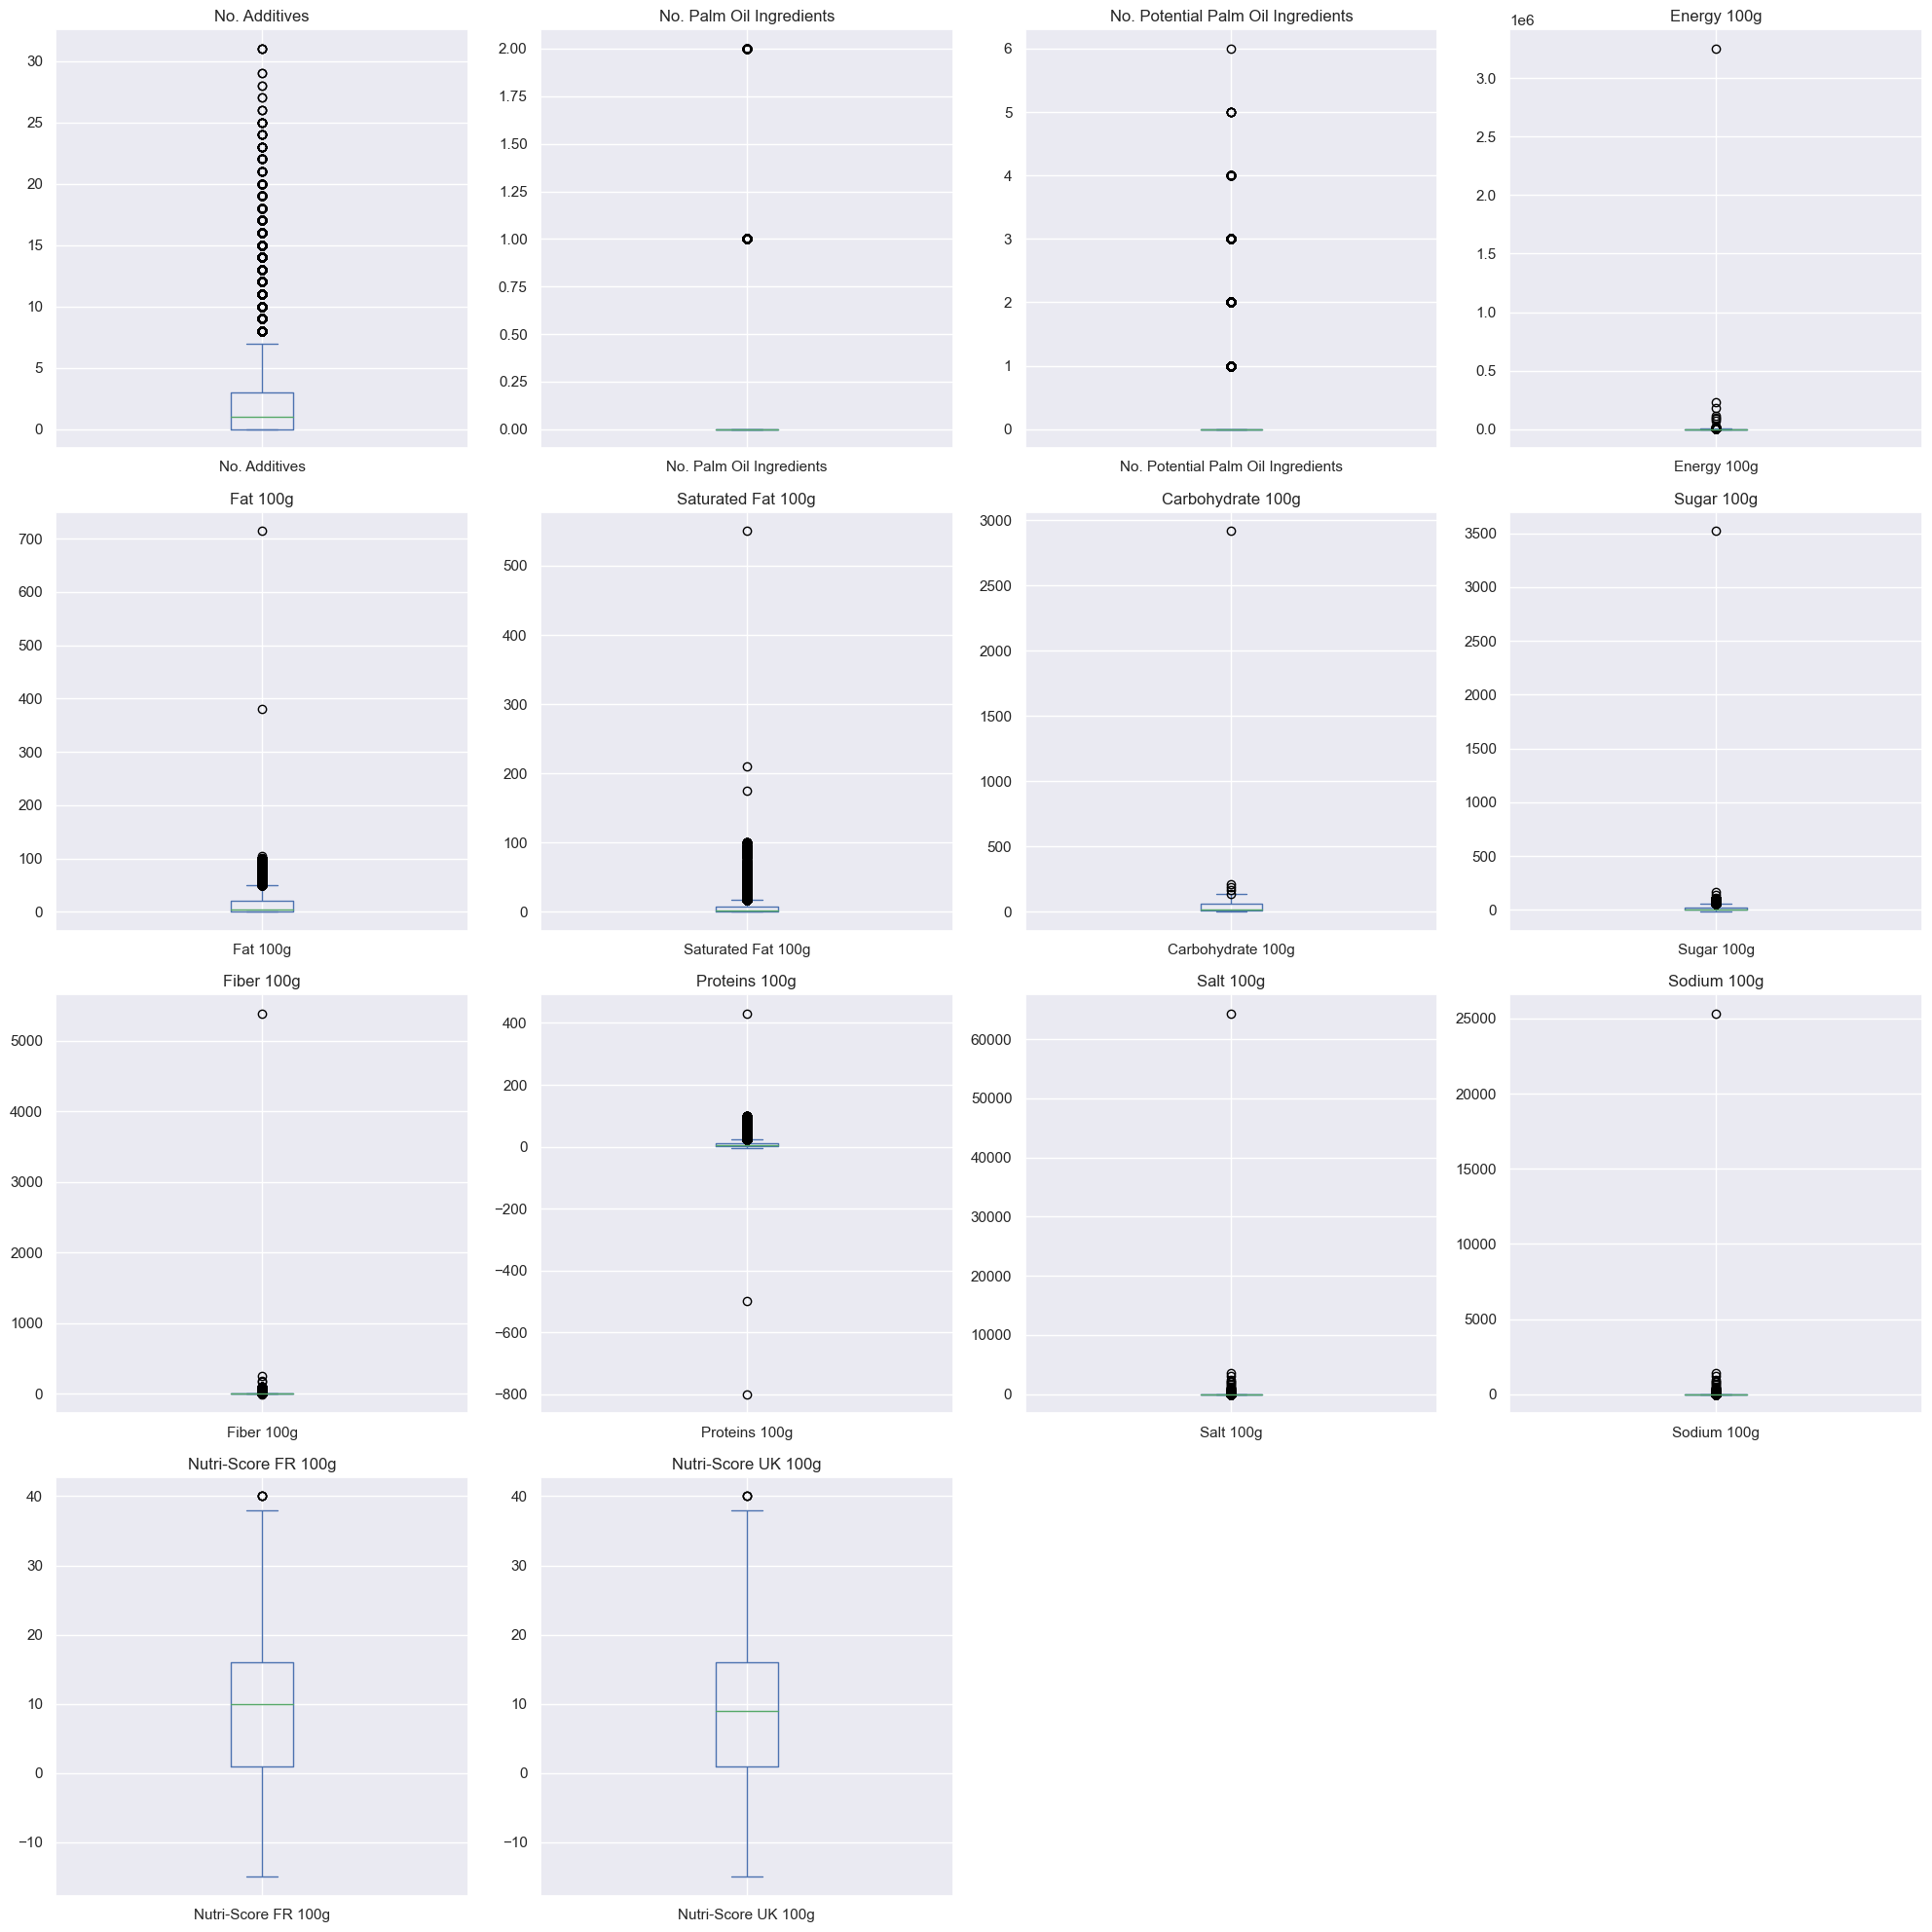

In [37]:
def plot_boxplots(df):
    """
    Function to plot boxplots of all numeric columns in a DataFrame.
    :param df: Input pandas DataFrame
    """

    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Calculate number of rows needed for subplots based on the number of numeric columns
    # We're creating a grid of subplots with 4 columns, so we need n/4 rows, rounded up
    n = len(numeric_cols)
    n_rows = (n + 3) // 4  # This is a common trick to round up integer division

    # Create the subplots
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 5))

    # Iterate over each axis and each numeric column together
    for ax, col in zip(axes.flatten(), numeric_cols):
        # Plot a boxplot of the current column on the current axis
        df[col].plot(kind='box', ax=ax)
        # Set the title of the current axis to the column name
        ax.set_title(col)

    # If the number of numeric columns is not a multiple of 4, some subplots will be empty
    # These should be removed to clean up the display
    if n % 4:
        # Remove the empty subplots by deleting the axes
        for i in range(n, n_rows * 4):
            fig.delaxes(axes.flatten()[i])

    # Adjust the layout so everything fits nicely
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function to plot boxplots
plot_boxplots(df)

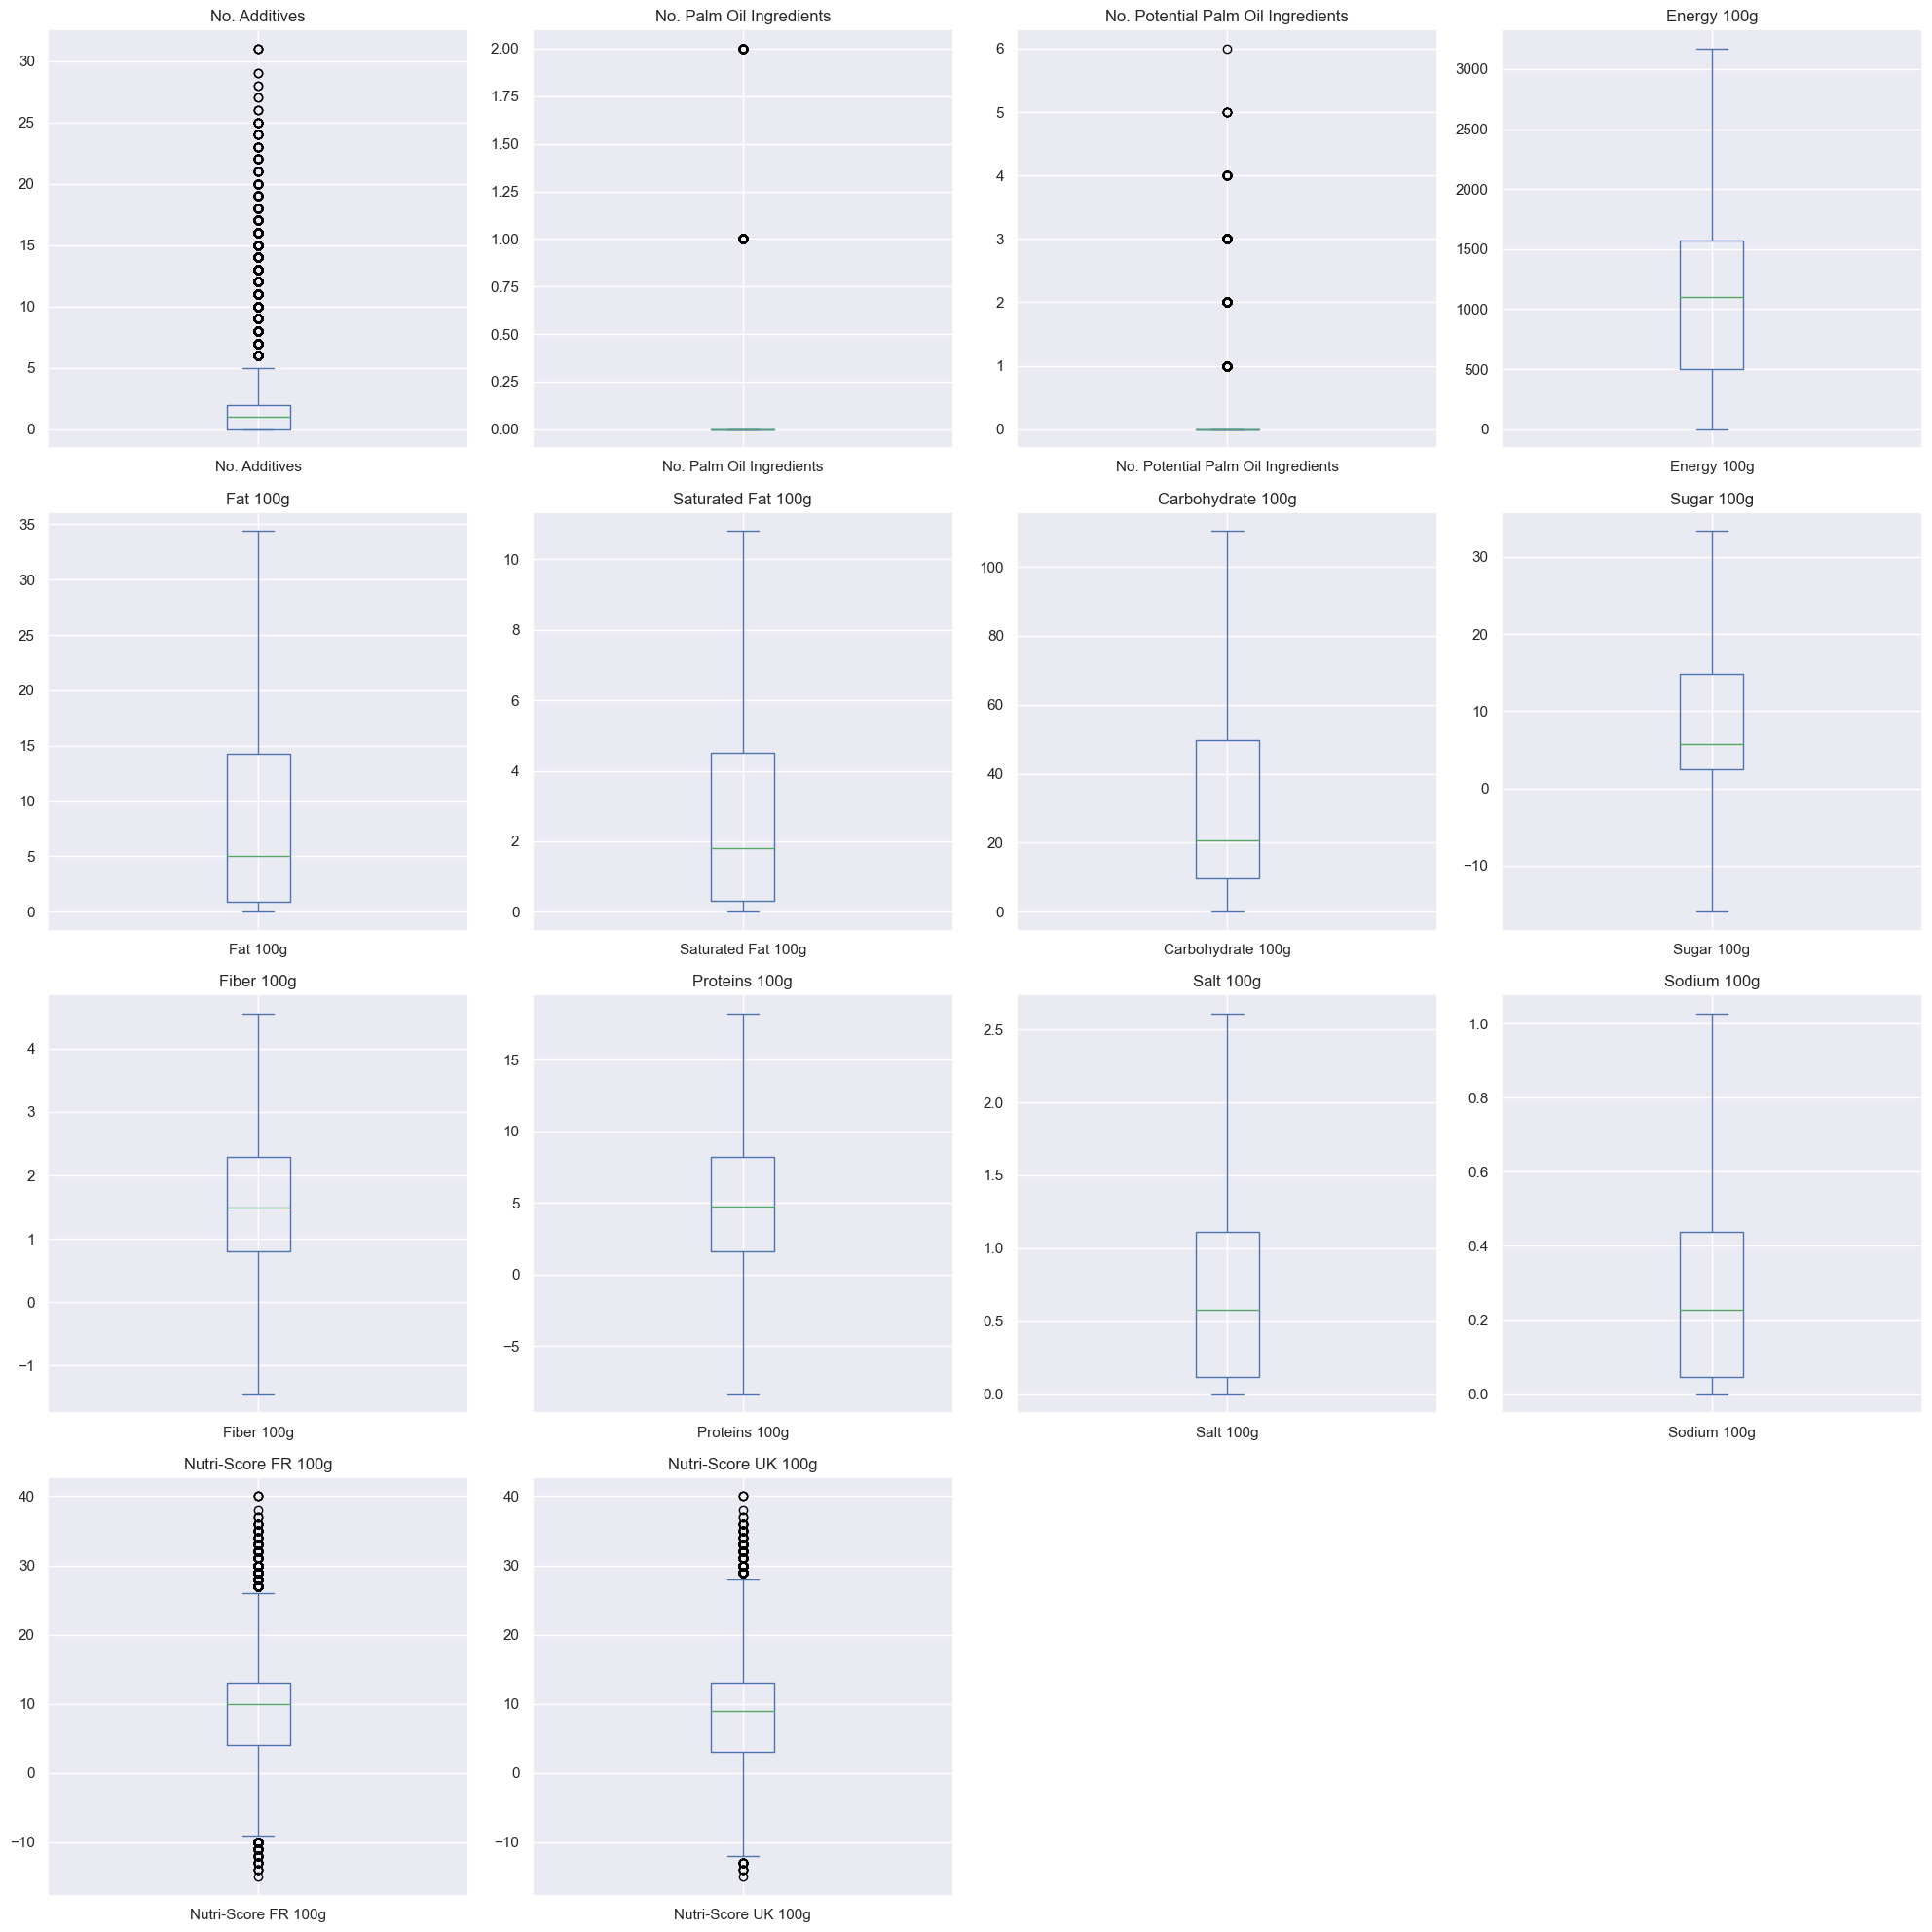

In [38]:
# Define relevant variables
variables = df.columns.to_list()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Columns to ignore during outlier treatment
ignore_cols = ['Nutri-Score FR 100g', 
               'Nutri-Score UK 100g', 
               'No. Additives', 
               'No. Palm Oil Ingredients', 
               'No. Potential Palm Oil Ingredients']

# Create an imputer object for numeric columns, median strategy is chosen to minimize the impact of outliers
numeric_imputer = SimpleImputer(strategy='median')

# Create an imputer object for categorical columns, most_frequent strategy is chosen for simplicity
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Define thresholds for missing values and quantiles
missing_value_threshold = 0.5
upper_limit = 0.75
lower_limit = 0.25
factor = 1.5  # Factor for outlier detection

# Iterate over each column in the dataframe
for column in variables:
    missing_values_count = df[column].isnull().sum()
    total_values = len(df[column])
    
    # If less than half the values are missing, impute the missing values
    if missing_values_count / total_values <= missing_value_threshold:
        # If column is numeric
        if column in numeric_cols:
            # Impute with median for numeric columns
            df[column] = numeric_imputer.fit_transform(df[column].values.reshape(-1, 1)).flatten()

            # If column is a floating point column and not in the ignore list, clip outliers
            if (column not in ignore_cols):
                # Calculate IQR
                Q1 = df[column].quantile(lower_limit)
                Q3 = df[column].quantile(upper_limit)
                IQR = Q3 - Q1
                
                # Calculate upper and lower fences for outlier detection
                lower_fence = Q1 - (factor*IQR)
                upper_fence = Q3 + (factor*IQR)
                
                # Clip (limit) values to upper and lower fences
                df[column] = df[column].clip(lower=lower_fence, upper=upper_fence)

        else:
            # Impute with mode (most frequent) for categorical columns
            df[column] = categorical_imputer.fit_transform(df[column].values.reshape(-1, 1)).flatten()

    else:
        # If more than half the values are missing, drop the column
        df.drop(column, axis="columns", inplace=True)

# Call the function to plot boxplots
plot_boxplots(df)

# Final DataFrame

In [39]:
print(df.shape)
df

(320772, 18)


,Product,Brand,Country,No. Additives,No. Palm Oil Ingredients,No. Potential Palm Oil Ingredients,Nutrition Grade FR,Energy 100g,Fat 100g,Saturated Fat 100g,Carbohydrate 100g,Sugar 100g,Fiber 100g,Proteins 100g,Salt 100g,Sodium 100g,Nutri-Score FR 100g,Nutri-Score UK 100g
0,Farine de blé noir,Ferme t'y R'nao,en:FR,1.0,0.0,0.0,d,1100.0,5.000,1.79,20.60,5.71,1.50,4.76,0.58166,0.229,10.0,9.0
1,Banana Chips Sweetened (Whole),Carrefour,US,0.0,0.0,0.0,d,2243.0,28.570,10.80,64.29,14.29,3.60,3.57,0.00000,0.000,14.0,14.0
2,Peanuts,Torn & Glasser,US,0.0,0.0,0.0,b,1941.0,17.860,0.00,60.71,17.86,4.55,17.86,0.63500,0.250,0.0,0.0
3,Organic Salted Nut Mix,Grizzlies,US,0.0,0.0,0.0,d,2540.0,34.375,5.36,17.86,3.57,4.55,17.86,1.22428,0.482,12.0,12.0
4,Organic Polenta,Bob's Red Mill,US,0.0,0.0,0.0,d,1552.0,1.430,1.79,77.14,5.71,4.55,8.57,0.58166,0.229,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320767,Tomato & ricotta,Panzani,en:RO,1.0,0.0,0.0,d,1100.0,5.000,1.79,20.60,5.71,1.50,4.76,0.58166,0.229,10.0,9.0
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",Trader Joe's,US,0.0,0.0,0.0,b,0.0,0.000,0.00,0.00,0.00,0.00,0.00,0.00000,0.000,0.0,0.0
320769,乐吧泡菜味薯片,乐吧,China,1.0,0.0,0.0,d,1100.0,5.000,1.79,20.60,5.71,1.50,4.76,0.58166,0.229,10.0,9.0
320770,Tomates aux Vermicelles,Knorr,en:FR,1.0,0.0,0.0,d,1100.0,5.000,1.79,20.60,5.71,1.50,4.76,0.58166,0.229,10.0,9.0


In [40]:
df.describe()

,No. Additives,No. Palm Oil Ingredients,No. Potential Palm Oil Ingredients,Energy 100g,Fat 100g,Saturated Fat 100g,Carbohydrate 100g,Sugar 100g,Fiber 100g,Proteins 100g,Salt 100g,Sodium 100g,Nutri-Score FR 100g,Nutri-Score UK 100g
count,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000,320772.000000
mean,1.726413,0.015257,0.042875,1116.764954,9.471224,3.193048,29.303369,10.567090,1.729924,6.031976,0.780629,0.307368,9.424538,9.040032
std,2.238412,0.124065,0.238272,708.231093,10.962638,3.636847,25.867583,11.477896,1.429966,5.513716,0.774962,0.305082,7.530211,7.626390
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.010000,-1.450000,-8.360000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,502.000000,0.900000,0.300000,9.600000,2.500000,0.800000,1.600000,0.120000,0.047244,4.000000,3.000000
50%,1.000000,0.000000,0.000000,1100.000000,5.000000,1.790000,20.600000,5.710000,1.500000,4.760000,0.581660,0.229000,10.000000,9.000000
75%,2.000000,0.000000,0.000000,1569.000000,14.290000,4.500000,49.900000,14.840000,2.300000,8.240000,1.115060,0.439000,13.000000,13.000000
max,31.000000,2.000000,6.000000,3169.500000,34.375000,10.800000,110.350000,33.350000,4.550000,18.200000,2.607650,1.026634,40.000000,40.000000


# Histograms

- Most distributions are unimodal or bimodal 

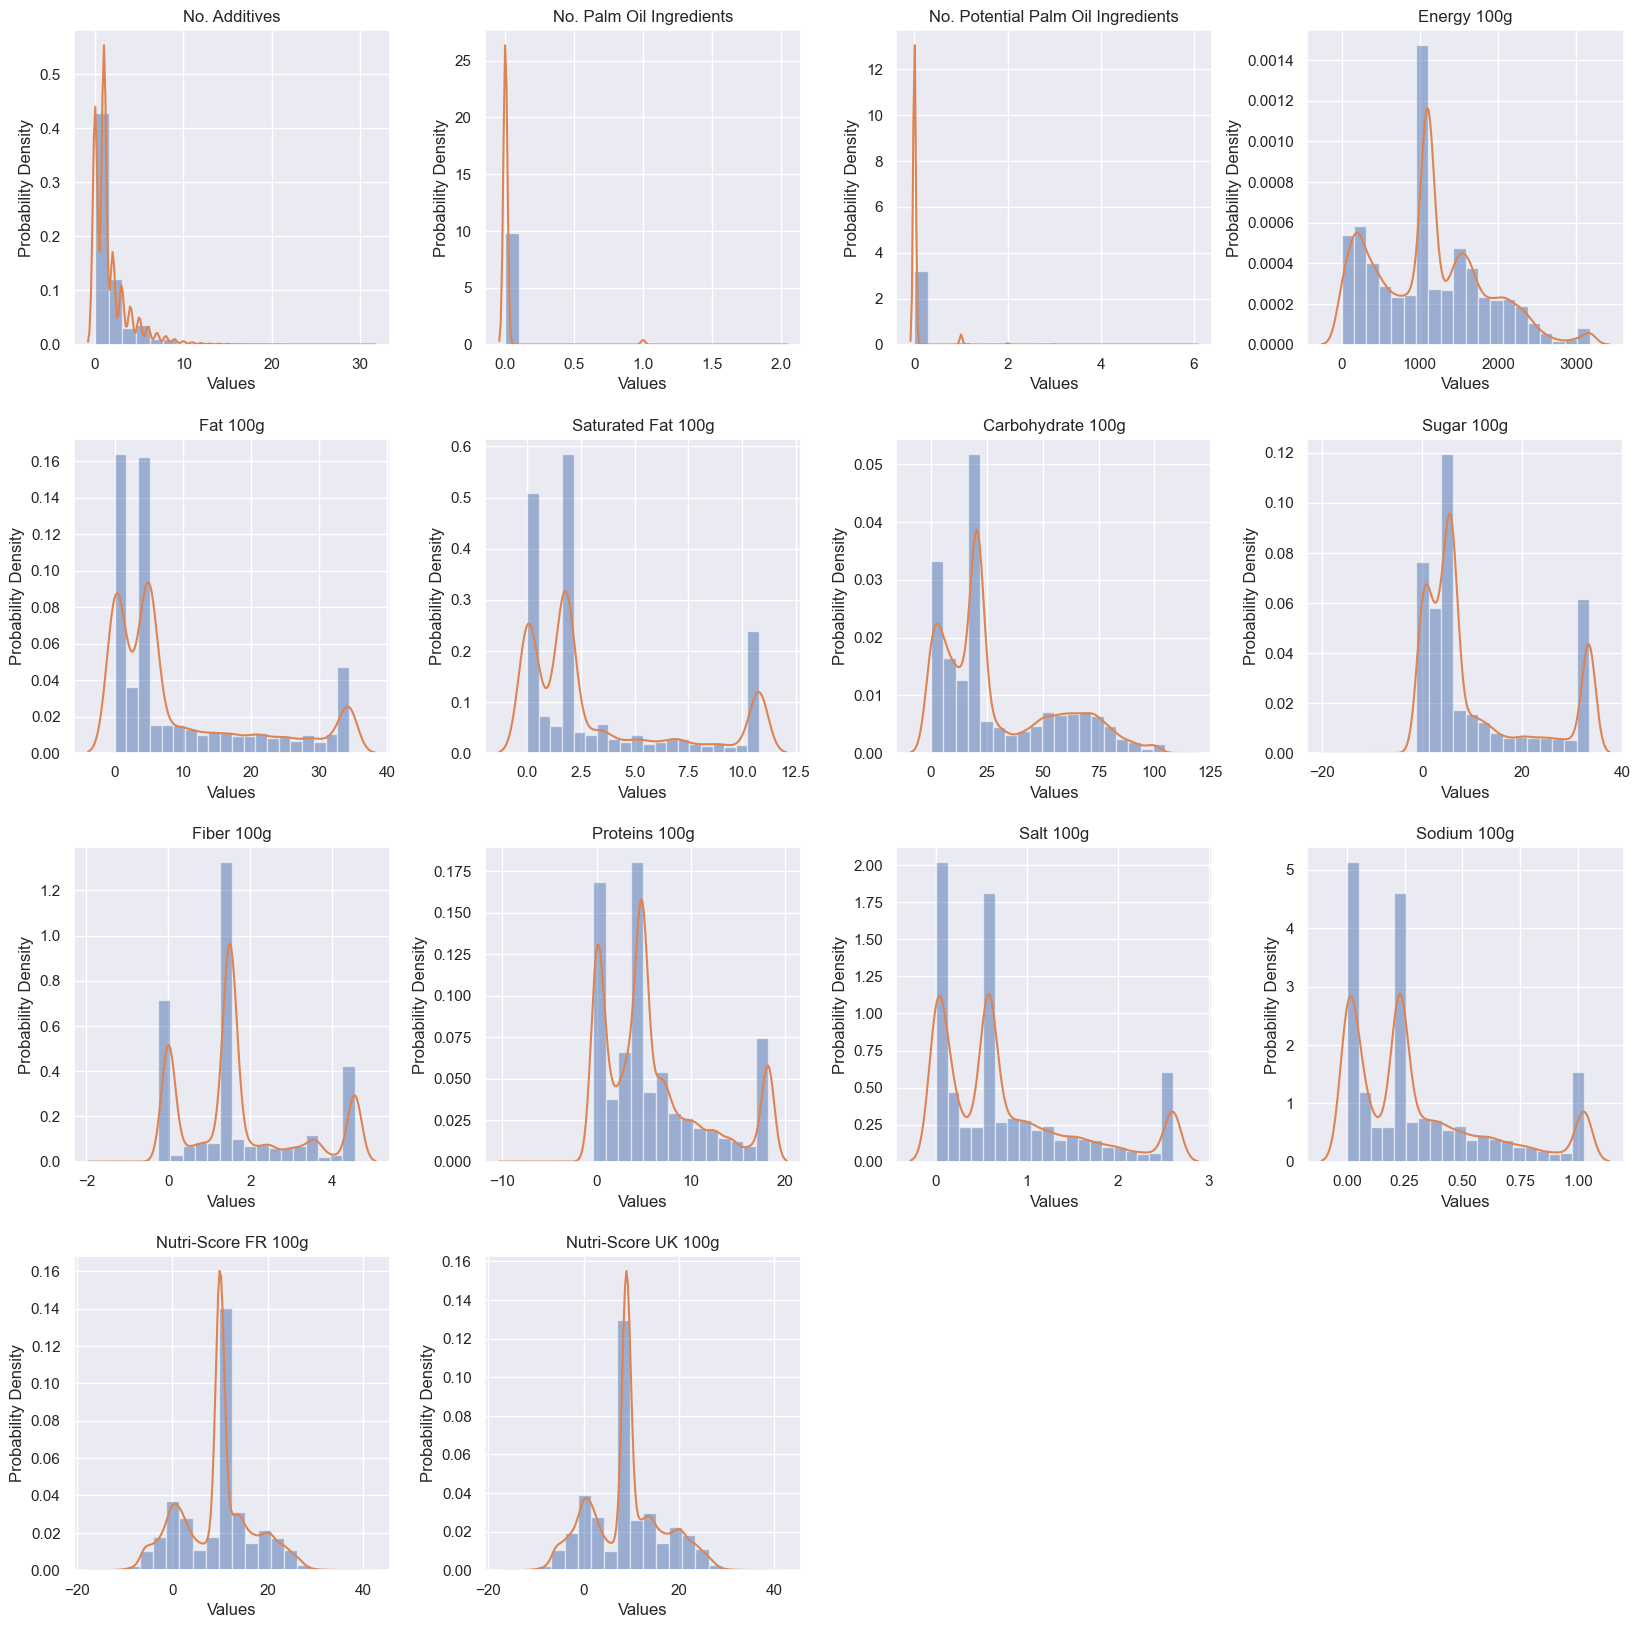

In [41]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Plotting the histogram
axes = df.hist(figsize=(20,20), bins=20, density=True, alpha=0.5)

# Loop through axes and numeric columns to add KDE plot
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.kdeplot(df[col], bw_adjust=1.5, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Values')
    ax.set_ylabel('Probability Density')

# Show the plot
plt.show()

# Bar Charts

- Bar charts showing the frequency of a category occuring
    - Missing values were replaced by most common value leading to extreme distributions

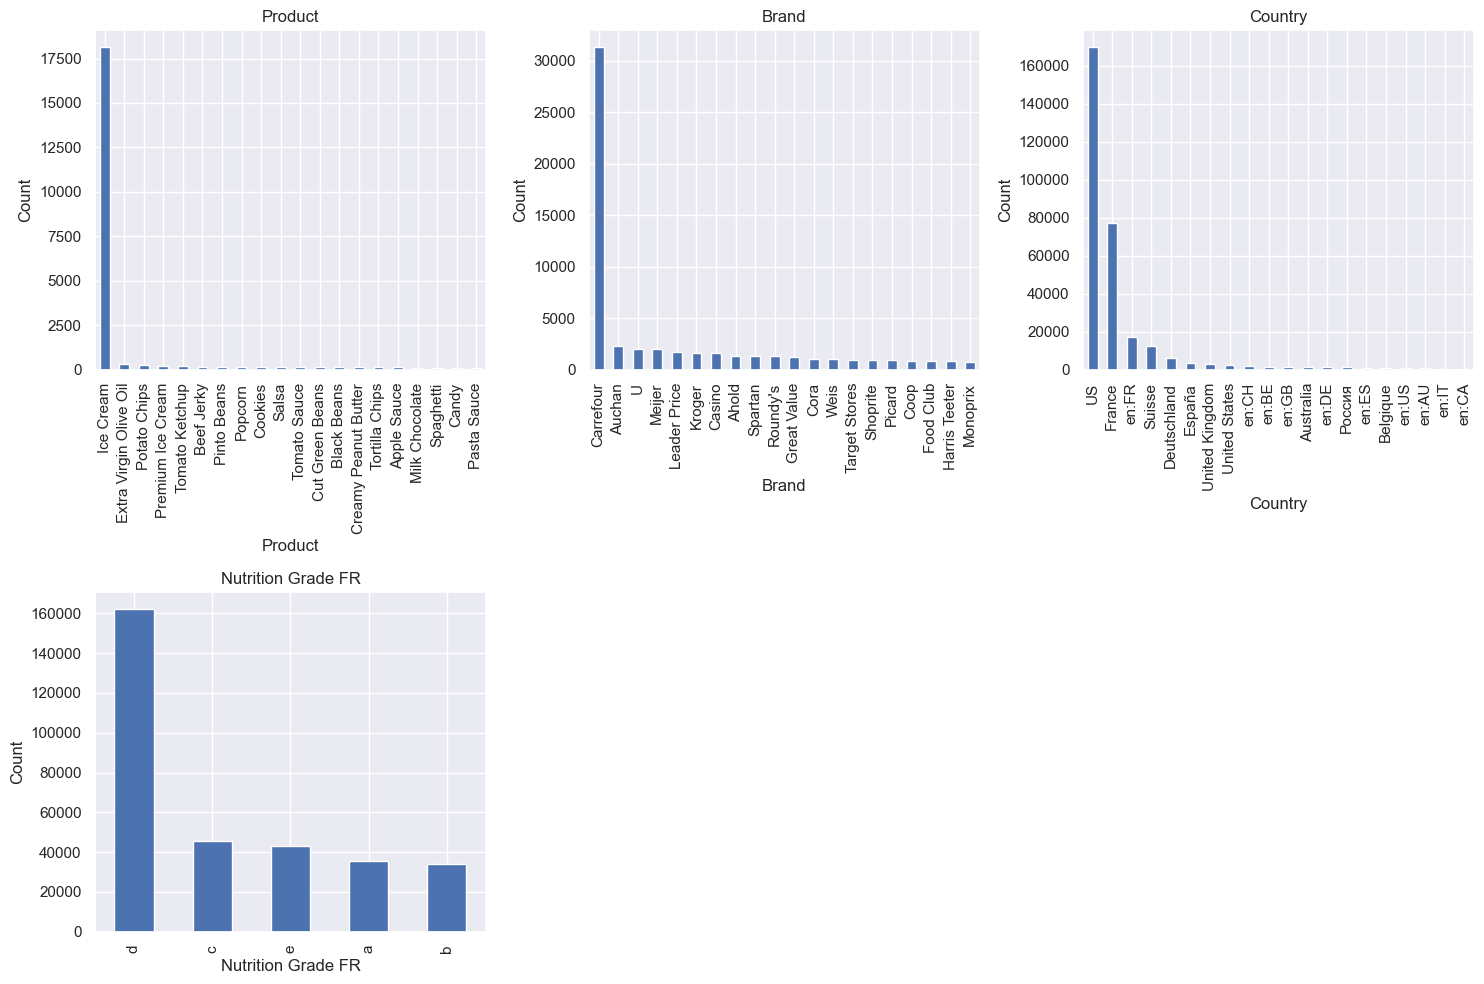

In [42]:
# Select columns with object data type from the DataFrame
encoded_df = df.select_dtypes(include='object')
object_cols = encoded_df.columns.to_list()

# Calculate number of rows needed for subplots
num_cols_per_row = 3
n = len(object_cols)
n_rows = (n + num_cols_per_row - 1) // num_cols_per_row  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, num_cols_per_row, figsize=(15, n_rows * 5))

# Plot the top 20 value counts for each object column
for index, (ax, col) in enumerate(zip(axes.flatten(), object_cols)):
    top_values = encoded_df[col].value_counts().head(20)
    top_values.plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Count')

# Remove empty subplots
for i in range(n, n_rows * num_cols_per_row):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Scatter Plots

- One variable plotted against another variable with the color being the nutritional grade
    - There are several plots that show weak to moderate positive relationships
    - These same plots also show a clear classification of nutritional grade 

```python
# Create a color map for unique Nutrition grades
unique_grades = df['Nutrition Grade FR'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_grades)))
color_map = {grade: colors[i] for i, grade in enumerate(unique_grades)}

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate number of rows needed for subplots
n = len(numeric_cols)
n_rows = n * (n - 1) // 2
n_cols = 4

# Prepare the subplot grid
n_full_rows = n_rows // n_cols
n_extra_plots = n_rows % n_cols
fig, axes = plt.subplots(n_full_rows + (1 if n_extra_plots else 0), n_cols, figsize=(24, 5 * n_rows // n_cols))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over pairs of columns and create scatter plots
i = 0
for col1_idx in range(n):
    for col2_idx in range(col1_idx + 1, n):
        ax = axes[i]
        df.plot(kind='scatter', x=numeric_cols[col1_idx], y=numeric_cols[col2_idx], 
                c=df['Nutrition Grade FR'].map(color_map), ax=ax, colorbar=False)
        ax.set_title(f'{numeric_cols[col1_idx]} vs {numeric_cols[col2_idx]}')
        i += 1

# Remove empty subplots
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

# Add legend patches
legend_patches = [mpatches.Patch(color=color_map[grade], label=grade) for grade in unique_grades]
fig.legend(handles=legend_patches, title="Nutrition Grade FR", loc='center left', borderaxespad=0., bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

```

# Linear Regression

This is the output of an Ordinary Least Squares (OLS) regression, which is often used in econometrics and statistics to estimate the relationships between a dependent variable and one or more independent variables. Let's interpret the key aspects of this output:

1. **Dependent Variable**: The dependent variable, or the variable you are trying to explain, is "Nutri-Score UK 100g."

2. **R-squared**: This value of 0.816 suggests that about 81.6% of the variability in the dependent variable "Nutri-Score UK 100g" can be explained by the model. It's a measure of how well the independent variables explain the dependent variable.

3. **Adjusted R-squared**: Also 0.816, which is the R-squared value adjusted for the number of predictors in the model. This metric is important when comparing models with different numbers of predictors.

4. **F-statistic**: The F-test checks the hypothesis that all regression coefficients are equal to zero. The p-value associated with the F-statistic is 0.00, indicating that the overall model is statistically significant.

5. **Coefficients Table**:
    - The "coef" column provides the estimated coefficients for each independent variable.
    - The "std err" column gives the standard error of each coefficient.
    - The "t" column provides the t-values, indicating the statistical significance of each coefficient.
    - The "P>|t|" column provides the p-values for the t-tests of each coefficient. 
    - The "[0.025, 0.975]" columns provide the 95% confidence interval for each coefficient.

6. **P-values**: If a p-value is less than 0.05 (common threshold), the corresponding variable is considered statistically significant. In this model, all variables have p-values less than 0.05, suggesting that they are all statistically significant predictors of the dependent variable.

7. **Other Statistics**:
    - The Durbin-Watson statistic tests for autocorrelation in the residuals. A value close to 2 suggests no autocorrelation.
    - Omnibus test and the Jarque-Bera (JB) test are tests for the normality of the residuals. A low p-value (like 0.00) suggests the residuals are not normally distributed.
    - The skewness and kurtosis values provide information on the shape of the distribution of the residuals.
  
8. **Notes**:
    - The comment on the condition number being large suggests potential multicollinearity issues, which means some independent variables are correlated with others. Multicollinearity can make the coefficients unstable and difficult to interpret.

To summarize, the model seems to explain a significant proportion of the variance in the "Nutri-Score UK 100g". However, as the notes suggest, there might be issues related to multicollinearity which could affect the stability and interpretation of coefficients.

                             OLS Regression Results                            
Dep. Variable:     Nutri-Score UK 100g   R-squared:                       0.816
Model:                             OLS   Adj. R-squared:                  0.816
Method:                  Least Squares   F-statistic:                 1.184e+05
Date:                 Sat, 19 Aug 2023   Prob (F-statistic):               0.00
Time:                         07:37:10   Log-Likelihood:            -8.3548e+05
No. Observations:               320772   AIC:                         1.671e+06
Df Residuals:                   320759   BIC:                         1.671e+06
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

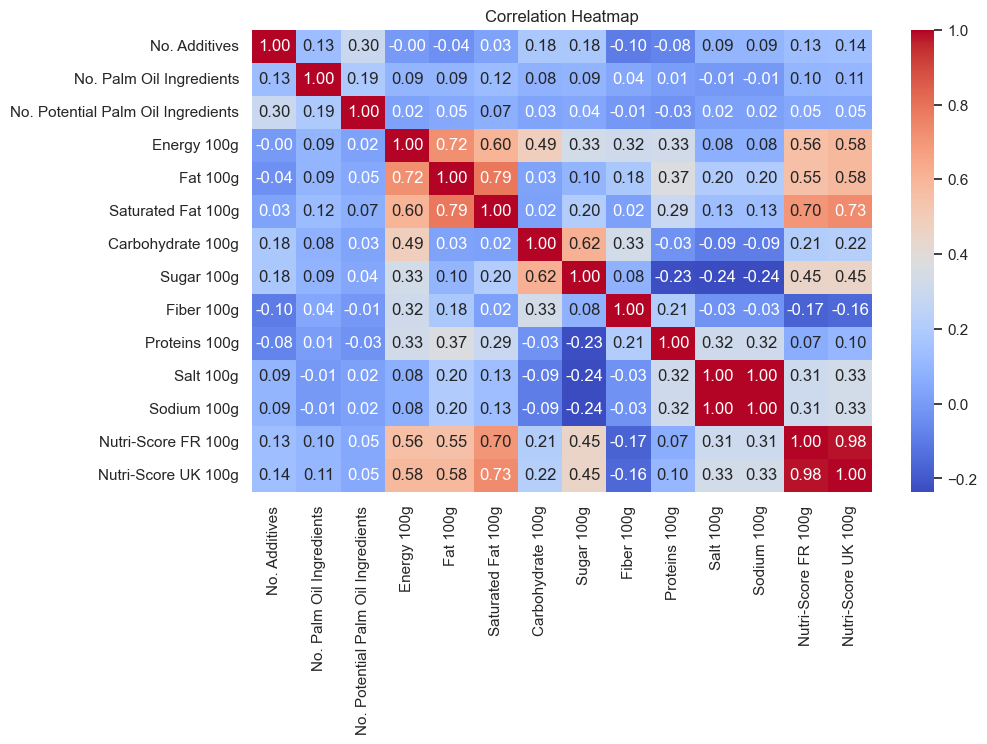

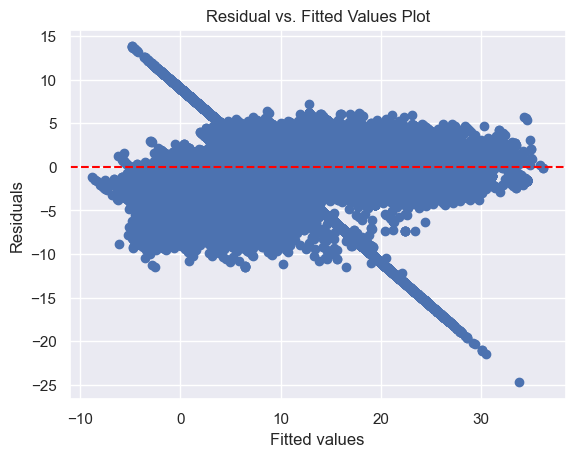

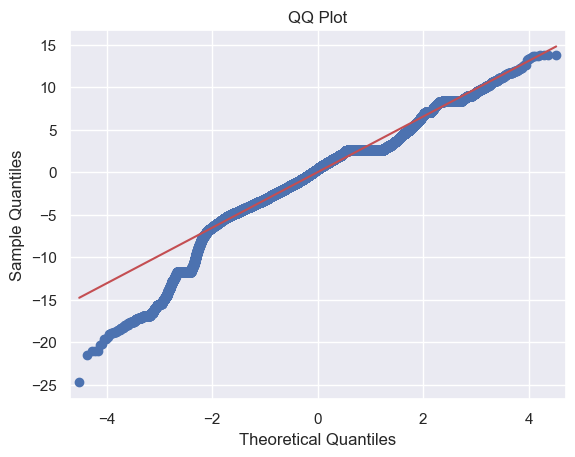

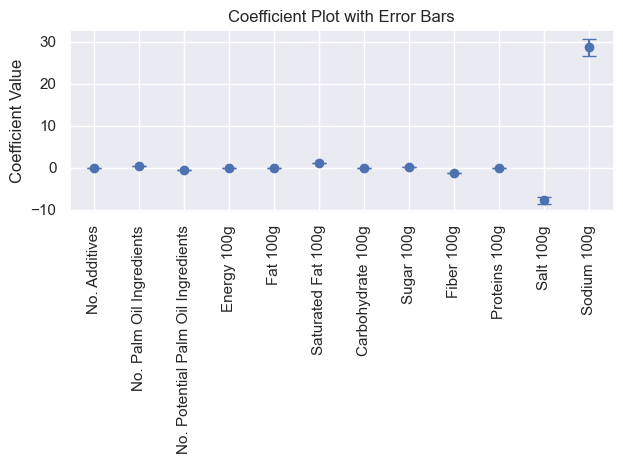

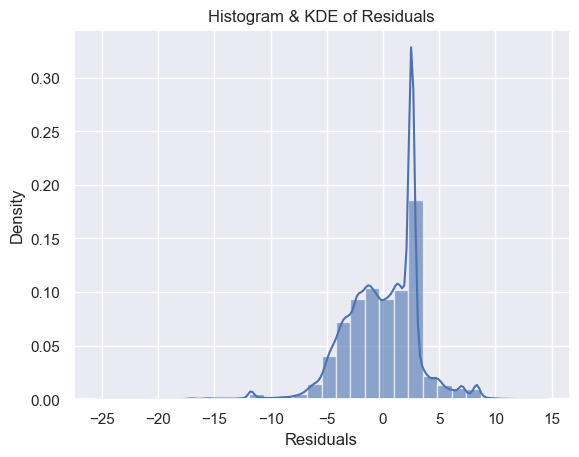

In [43]:
# Filter Numeric Columns and Split into Features and Target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols[:-2]]
y = df[numeric_cols[-1]]

# Fit the Model
X_with_constant = sm.add_constant(X)
model = sm.OLS(y, X_with_constant).fit()
print(model.summary())

# 1. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 2. Residual vs. Fitted Values Plot
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Values Plot')
plt.show()

# 3. QQ Plot
qqplot(model.resid, line='s')
plt.title('QQ Plot')
plt.show()

# 4. Coefficient Plot
coefs = model.params[1:]  # excluding intercept
errors = model.bse[1:]
plt.errorbar(coefs.index, coefs.values, yerr=errors.values, fmt='o', capsize=5)
plt.ylabel('Coefficient Value')
plt.title('Coefficient Plot with Error Bars')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 5. Histogram & KDE of Residuals
plt.hist(model.resid, bins=30, density=True, alpha=0.6, color='b')
sns.kdeplot(model.resid)
plt.xlabel('Residuals')
plt.title('Histogram & KDE of Residuals')
plt.show()

# 6. Scale-Location Plot
#standardized_residuals = model.get_influence().resid_studentized_internal
#sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))
#plt.scatter(model.fittedvalues, sqrt_standardized_residuals, alpha=0.6)
#plt.hlines(0, xmin=min(model.fittedvalues), xmax=max(model.fittedvalues), color='red', linestyle='--')
#plt.xlabel('Fitted values')
#plt.ylabel('Sqrt(|Standardized Residuals|)')
#plt.title('Scale-Location Plot')
#plt.show()

# 7. Influence Plot
#fig, ax = plt.subplots(figsize=(8, 6))
#plot_leverage_resid2(model, ax=ax)
#plt.title('Influence Plot')
#plt.show()

# 8. Partial Regression Plots
#fig = plt.figure(figsize=(10, 8))
#plot_partregress_grid(model, fig=fig)
#plt.show()

# 9. VIF (Not a plot but a useful diagnostic metric)
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
#vif["features"] = model.model.exog_names
#vif.round(12)


# PCA

**Principal Component Analysis (PCA) Findings:**

1. **Explained Variance & Cumulative Variance**:
   * The first principal component (PC1) explains 30.57% of the total variance in the data.
   * The first two principal components combined (PC1 & PC2) explain approximately 47.71% of the total variance.
   * The first five components together explain approximately 78.65% of the variance, indicating that they contain most of the information in the dataset.
   * All components together (PC1 to PC14) explain 100% of the variance, which is expected.

2. **Loading Factors for Each Component**:

   **PC1**:
   * PC1 is mostly influenced by the `Energy 100g`, `Fat 100g`, `Saturated Fat 100g`, `Nutri-Score FR 100g`, and `Nutri-Score UK 100g` with loadings of approximately 0.79, 0.79, 0.83, 0.88, and 0.91 respectively. This indicates that PC1 might represent the general nutritional score and energy content of food.

   **PC2**:
   * PC2 has strong positive associations with `Carbohydrate 100g` and `Sugar 100g` (0.59 and 0.71, respectively) and a strong negative association with `Salt 100g` and `Sodium 100g` (both around -0.78). This component might be contrasting sugar and carbohydrate content against salt and sodium content.

   **PC3**:
   * The third component, PC3, is strongly associated with `No. Additives` (0.56) in a positive direction and with `Energy 100g`, `Fat 100g`, `Saturated Fat 100g`, `Fiber 100g`, and `Proteins 100g` in a negative direction. This component might be capturing a contrast between additives and some major nutritional contents.

   **PC4**:
   * PC4 has positive loadings for `No. Additives`, `Carbohydrate 100g`, and `Fiber 100g`, and negative loadings for `Saturated Fat 100g`, `Nutri-Score FR 100g`, and `Nutri-Score UK 100g`. This component seems to be contrasting carbohydrate and fiber content against saturated fats and nutritional scores.

   **Other Components**:
   * Subsequent components (from PC5 onward) explain less variance individually, and their interpretations become less intuitive due to the nature of PCA, which seeks orthogonal (uncorrelated) components. It's common in PCA analyses for the first few components to capture broader, more easily interpretable patterns in the data, while later components capture more specific or nuanced variance. For detailed analysis, each component's loading factors should be evaluated separately.

3. **Considerations and Recommendations**:
   * The first few components (especially PC1 to PC4) capture significant variance and are more interpretable. They could be used in subsequent analyses or modeling efforts to reduce dimensionality while retaining most of the information.
   * While the last few components (e.g., PC13 and PC14) explain very little variance, it's important to check if they capture any specific or nuanced patterns that could be relevant for specific analyses.
   * When interpreting the loading factors, it's crucial to consider both the magnitude and direction. High magnitude (regardless of being positive or negative) indicates strong association, while the sign (positive/negative) shows the direction of the association.
   * It's also noteworthy that `Salt 100g` and `Sodium 100g` have almost identical loading patterns across components, suggesting that they convey very similar information. In future analyses or modeling efforts, using one of them might be sufficient.

In summary, this PCA analysis reveals key patterns and relationships in the data, especially concerning nutritional scores, energy content, and some specific nutritional components.

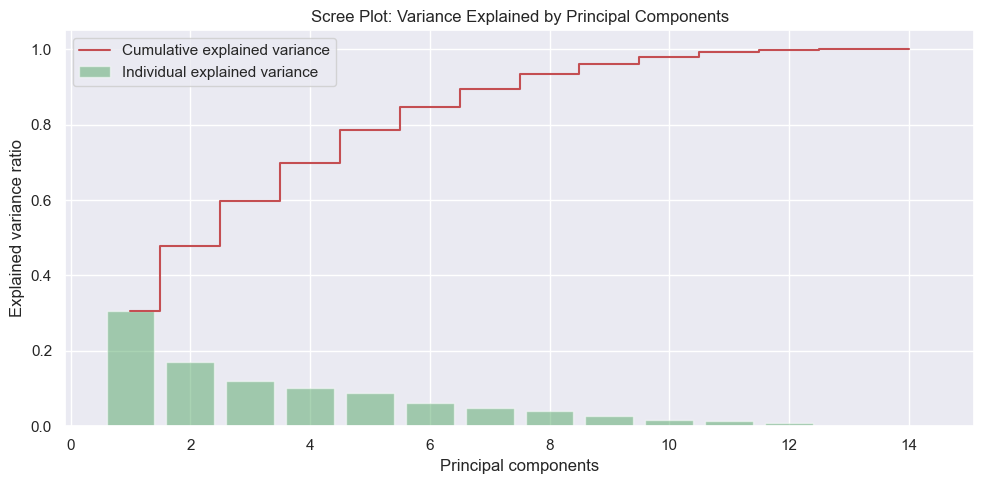

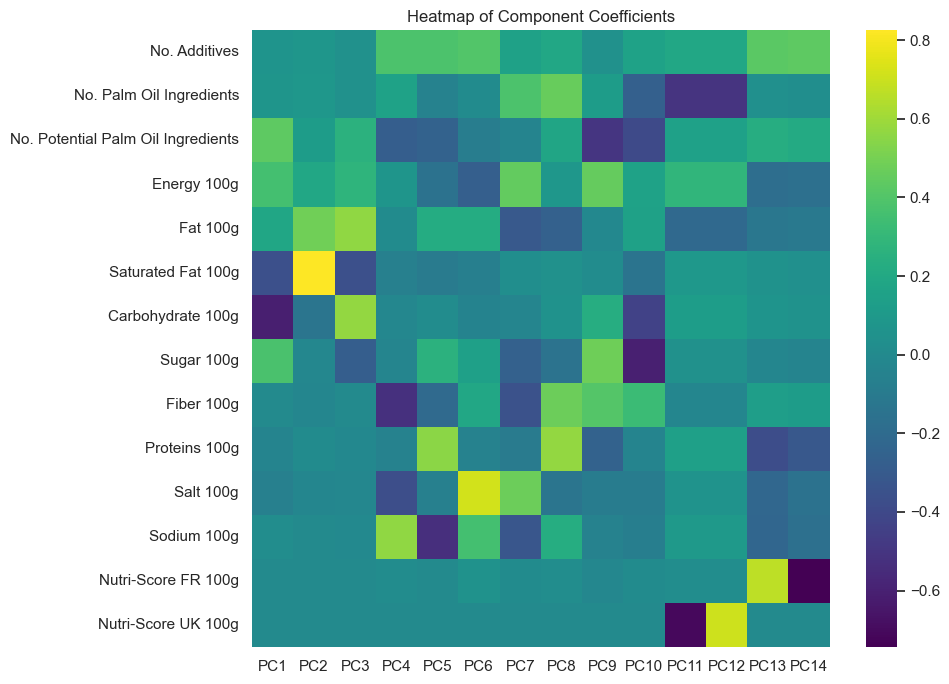

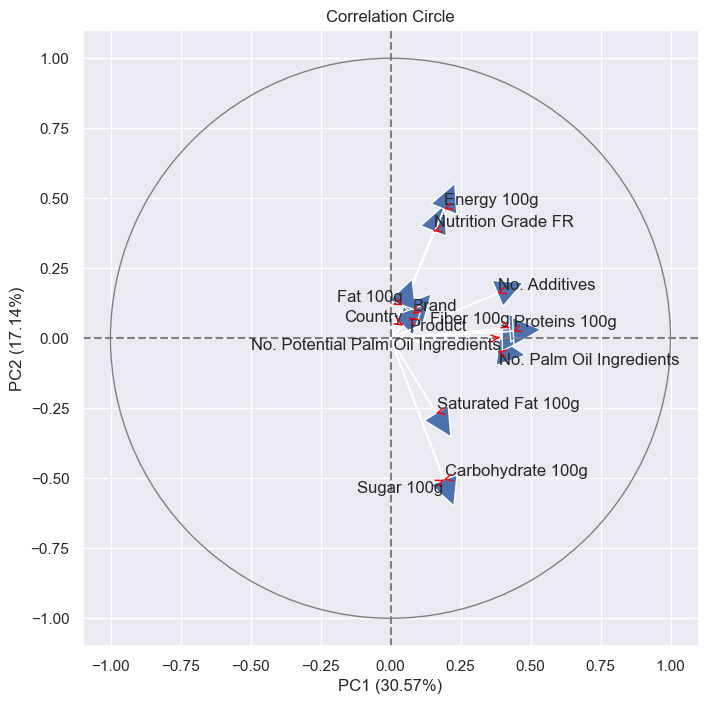

In [44]:
def plot_variance_explained(pca):
    """
    Plot the variance explained by each component.
    """
    explained_var = pca.explained_variance_ratio_
    cum_explained_var = np.cumsum(explained_var)

    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center',
            label='Individual explained variance', color='g')
    plt.step(range(1, len(explained_var) + 1), cum_explained_var, where='mid',
             label='Cumulative explained variance', color='r')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.title('Scree Plot: Variance Explained by Principal Components')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_loading_heatmap(pca, df):
    """
    Plot a heatmap of the PCA components' coefficients.
    """
    components = pca.components_
    numeric_cols = df.select_dtypes(include=np.number).columns.to_list()

    plt.figure(figsize=(10, len(components)*0.5))
    sns.heatmap(components, cmap='viridis', yticklabels=numeric_cols,
                xticklabels=[f'PC{i+1}' for i in range(len(components))],
                cbar_kws={"orientation": "vertical"})
    plt.yticks(rotation=0)
    plt.title('Heatmap of Component Coefficients')
    plt.tight_layout()
    plt.show()

def plot_correlation_circle(df, dimension='2d'):
    """
    Plot a correlation circle or sphere for PCA results.
    """
    numeric_cols = df.select_dtypes(include=np.number).columns.to_list()
    df_std = StandardScaler().fit_transform(df[numeric_cols])
    pca = PCA().fit(df_std)

    plot_variance_explained(pca)
    plot_loading_heatmap(pca, df)

    if dimension == '2d':
        fig, ax = plt.subplots(figsize=(8, 8))
        pcs = pca.components_
        texts = []
        for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
            plt.arrow(0, 0, x, y, head_width=0.1, head_length=0.1)
            texts.append(plt.text(x, y, df.columns[i]))

        circle = plt.Circle((0, 0), 1, color='gray', fill=False)
        ax.add_artist(circle)
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.axvline(0, color='grey', linestyle='--')
        plt.axhline(0, color='grey', linestyle='--')
        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
        plt.title("Correlation Circle")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True)
        plt.show()

    elif dimension == '3d':
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        pcs = pca.components_

        for i, (x, y, z) in enumerate(zip(pcs[0, :], pcs[1, :], pcs[2, :])):
            ax.quiver(0, 0, 0, x, y, z, arrow_length_ratio=0.1, color="black")
            ax.text(x, y, z, df.columns[i], fontsize=10)

        # Create a sphere
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_wireframe(x, y, z, color="gray", alpha=0.1)

        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
        ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]:.2%})")
        ax.set_title("Correlation Sphere")
        plt.show()

    else:
        raise ValueError("Only '2d' and '3d' are valid dimensions.")

# Example usage
plot_correlation_circle(df, dimension='2d')


# ANOVA

### 1. ANOVA Results:
**F-statistic: 27921.0926**
**P-value: 0.0000**
With a p-value of 0.0000, the differences among the group means for Nutrition Grade FR are statistically significant.

- The **F-statistic** is a measure to see if the means of different groups are significantly different. A large F-statistic suggests that at least one group mean is different from the others. Here, the F-statistic is quite high (27921.0926).

- The **P-value** is a test of the hypothesis that the group means are all the same. A small P-value (often less than 0.05) indicates that you can reject this hypothesis. Here, the P-value is 0.0000, meaning it's very close to zero, which provides strong evidence against the hypothesis that all group means are the same. Hence, there's a significant difference between at least two of the group means.

### 2. Eta-squared:
**Eta-squared: 0.2583**
**Interpretation: Large effect**

- **Eta-squared (η^2)** is a measure of effect size for the ANOVA test. It tells us the proportion of total variation that's explained by the variation between the groups. Here, η^2 is 0.2583, which means that approximately 25.83% of the total variation in the data is explained by the Nutrition Grade FR. 

- The interpretation categorizes this effect size as a "Large effect." This suggests that the Nutrition Grade FR has a strong association with the "Energy 100g" variable.

### 3. Assumptions:
**Levene's Test:** Assumption of homogeneity of variances NOT satisfied.

- **Levene's Test** checks for homogeneity of variances, meaning whether the different groups have the same variance. In this case, the assumption is not satisfied, indicating that there's a significant difference in the variances of the groups.

**Shapiro-Wilk Test:** Assumption of normality NOT satisfied for all nutrition grades (a, b, c, d, e).

- The **Shapiro-Wilk Test** checks if the data is normally distributed within each group. A non-significant result suggests the data does not deviate from a normal distribution. However, the test results indicate that none of the Nutrition Grade FR groups (a, b, c, d, e) satisfy the normality assumption.

### Summary:
The ANOVA test indicates that the Nutrition Grade FR has a significant effect on the "Energy 100g" with a large effect size. However, the data violates two critical assumptions of ANOVA: homogeneity of variances and normality. Therefore, while the ANOVA results are statistically significant, they should be interpreted with caution due to the violated assumptions. Alternative non-parametric methods might be considered for a more robust analysis.

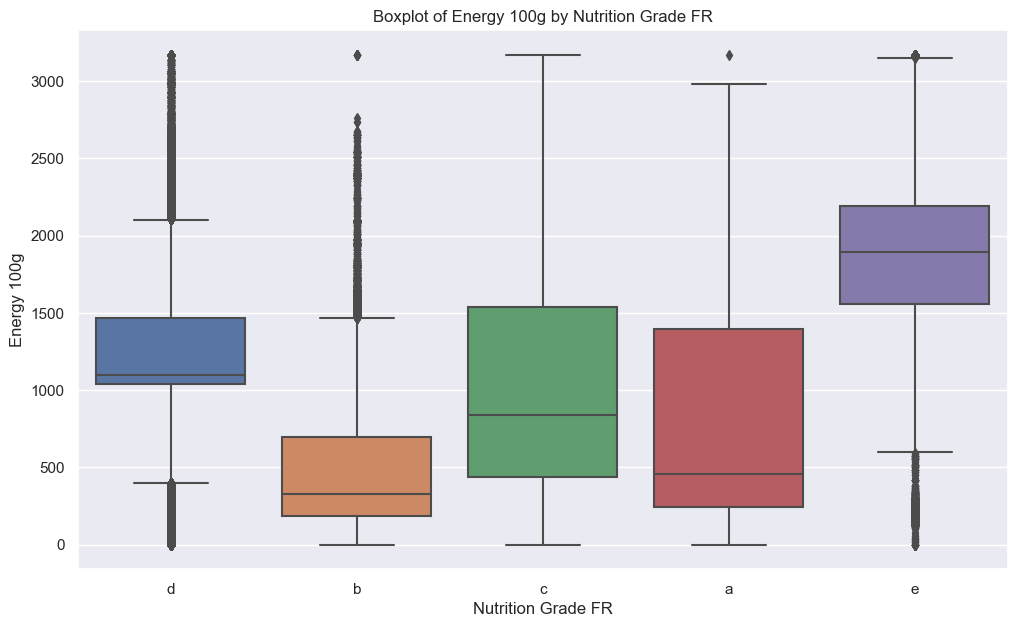

ANOVA Results for Energy 100g by Nutrition Grade FR:

F-statistic: 27921.0926
P-value: 0.0000

With a p-value of 0.0000, the differences among the group means for Nutrition Grade FR are statistically significant.
Eta-squared: 0.2583
Interpretation: Large effect

Levene's Test: Assumption of homogeneity of variances NOT satisfied.
Shapiro-Wilk Test for d: Assumption of normality NOT satisfied.
Shapiro-Wilk Test for b: Assumption of normality NOT satisfied.
Shapiro-Wilk Test for c: Assumption of normality NOT satisfied.
Shapiro-Wilk Test for a: Assumption of normality NOT satisfied.
Shapiro-Wilk Test for e: Assumption of normality NOT satisfied.


/Users/typhaine/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [45]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

def anova_test_and_visualize(df, numeric_col, categorical_col):
    # 1. ANOVA Test
    # Creating groups based on categorical_col values
    groups = [df[numeric_col][df[categorical_col] == category] for category in df[categorical_col].unique()]
    
    # Apply ANOVA test
    f_statistic, p_value = stats.f_oneway(*groups)
    
    # 2. Visualization
    plt.figure(figsize=(12, 7))
    sns.boxplot(x=categorical_col, y=numeric_col, data=df)
    plt.title(f'Boxplot of {numeric_col} by {categorical_col}')
    plt.show()
    
    # 3. Report Results
    print(f'ANOVA Results for {numeric_col} by {categorical_col}:\n')
    print(f'F-statistic: {f_statistic:.4f}')
    print(f'P-value: {p_value:.4f}')
    
    # Basic interpretation
    alpha = 0.05  # commonly used significance level
    if p_value < alpha:
        print(f"\nWith a p-value of {p_value:.4f}, the differences among the group means for {categorical_col} are statistically significant.")
    else:
        print(f"\nWith a p-value of {p_value:.4f}, the differences among the group means for {categorical_col} are not statistically significant.")

import scipy.stats as stats

def anova_assumptions(df, numeric_col, categorical_col):
    # 1. Calculate Eta-squared
    groups = [df[numeric_col][df[categorical_col] == category] for category in df[categorical_col].unique()]
    
    # Apply ANOVA test
    f_statistic, p_value = stats.f_oneway(*groups)
    
    # Calculate SS_total
    ss_total = sum([(val - df[numeric_col].mean())**2 for val in df[numeric_col]])
    
    # Calculate SS_between
    ss_between = sum([len(group) * (group.mean() - df[numeric_col].mean())**2 for group in groups])
    
    # Calculate eta-squared
    eta_squared = ss_between / ss_total
    
    # 2. Interpret Eta-squared
    if eta_squared < 0.01:
        eta_interpretation = "Small effect"
    elif eta_squared < 0.06:
        eta_interpretation = "Medium effect"
    else:
        eta_interpretation = "Large effect"
    
    # 3. Check Assumptions of ANOVA
    # Homogeneity of variances
    _, p_value_levene = stats.levene(*groups)
    
    # Normality for each group
    shapiro_results = [stats.shapiro(group)[1] for group in groups]
    
    print(f'Eta-squared: {eta_squared:.4f}')
    print(f'Interpretation: {eta_interpretation}')
    
    # Reporting Levene's test result
    if p_value_levene < 0.05:
        print("\nLevene's Test: Assumption of homogeneity of variances NOT satisfied.")
    else:
        print("\nLevene's Test: Assumption of homogeneity of variances satisfied.")
    
    # Reporting Shapiro-Wilk test results for each group
    for idx, p in enumerate(shapiro_results):
        if p < 0.05:
            print(f"Shapiro-Wilk Test for {df[categorical_col].unique()[idx]}: Assumption of normality NOT satisfied.")
        else:
            print(f"Shapiro-Wilk Test for {df[categorical_col].unique()[idx]}: Assumption of normality satisfied.")

# Sample usage:
# data = create_quantile_category(data, 'Energy 100g')
# anova_assumptions(data, 'Energy 100g', 'Nutrition Grade FR')


# Sample usage:
data = create_quantile_category(data, 'Energy 100g')
anova_test_and_visualize(df, 'Energy 100g', 'Nutrition Grade FR')
anova_assumptions(df, 'Energy 100g', 'Nutrition Grade FR')


# MANOVA



The MANOVA results provide multivariate tests of significance for multiple dependent variables. In the given results, you have five independent variables (x0, x1, x2, x3, and x4) and their impact on a multivariate set of dependent variables. Let's break down the results:

1. **Independent Variable: x0**
   - **Wilks' lambda**: 0.5871, F(12, 320756) = 18795.26, p < 0.0001
   - **Pillai's trace**: 0.4129, F(12, 320756) = 18795.26, p < 0.0001
   - **Hotelling-Lawley trace**: 0.7032, F(12, 320756) = 18795.26, p < 0.0001
   - **Roy's greatest root**: 0.7032, F(12, 320756) = 18795.26, p < 0.0001

2. **Independent Variable: x1**
   - **Wilks' lambda**: 0.7648, F(12, 320756) = 8219.39, p < 0.0001
   - **Pillai's trace**: 0.2352, F(12, 320756) = 8219.39, p < 0.0001
   - **Hotelling-Lawley trace**: 0.3075, F(12, 320756) = 8219.39, p < 0.0001
   - **Roy's greatest root**: 0.3075, F(12, 320756) = 8219.39, p < 0.0001

3. **Independent Variable: x2**
   - **Wilks' lambda**: 0.4856, F(12, 320756) = 28316.22, p < 0.0001
   - **Pillai's trace**: 0.5144, F(12, 320756) = 28316.22, p < 0.0001
   - **Hotelling-Lawley trace**: 1.0594, F(12, 320756) = 28316.22, p < 0.0001
   - **Roy's greatest root**: 1.0594, F(12, 320756) = 28316.22, p < 0.0001

4. **Independent Variable: x3**
   - **Wilks' lambda**: 0.1871, F(12, 320756) = 116165.51, p < 0.0001
   - **Pillai's trace**: 0.8129, F(12, 320756) = 116165.51, p < 0.0001
   - **Hotelling-Lawley trace**: 4.3459, F(12, 320756) = 116165.51, p < 0.0001
   - **Roy's greatest root**: 4.3459, F(12, 320756) = 116165.51, p < 0.0001

5. **Independent Variable: x4**
   - **Wilks' lambda**: 0.2153, F(12, 320756) = 97404.65, p < 0.0001
   - **Pillai's trace**: 0.7847, F(12, 320756) = 97404.65, p < 0.0001
   - **Hotelling-Lawley trace**: 3.6441, F(12, 320756) = 97404.65, p < 0.0001
   - **Roy's greatest root**: 3.6441, F(12, 320756) = 97404.65, p < 0.0001

**Interpretation**:

- For all independent variables (x0 to x4), the tests of significance (Wilks' lambda, Pillai's trace, Hotelling-Lawley trace, and Roy's greatest root) all yield highly significant p-values (p < 0.0001). This means that each of these independent variables has a statistically significant multivariate effect on the set of dependent variables.
  
- Among the independent variables, `x3` has the highest F value of 116165.51, suggesting that it might have the most significant multivariate effect among the predictors, though all predictors exhibit strong effects.

In summary, all five predictors have a statistically significant multivariate effect on the set of dependent variables, as evidenced by the highly significant p-values across all test statistics.

In the context of MANOVA, \( \eta^2 \) (eta squared) represents the proportion of the total variance in the dependent variables that's associated with the variance of the independent variable. It is a measure of effect size. 

The formula for \( \eta^2 \) in MANOVA, using Wilks' lambda (\( \Lambda \)), is:

\[ \eta^2 = 1 - \Lambda \]

Here's how to compute \( \eta^2 \) for your given results:

1. **Independent Variable: x0**
    - Wilks' lambda: 0.5871
    - \( \eta^2 \) = 1 - 0.5871 = 0.4129 (which matches your provided Pillai's trace)

2. **Independent Variable: x1**
    - Wilks' lambda: 0.7648
    - \( \eta^2 \) = 1 - 0.7648 = 0.2352

3. **Independent Variable: x2**
    - Wilks' lambda: 0.4856
    - \( \eta^2 \) = 1 - 0.4856 = 0.5144

4. **Independent Variable: x3**
    - Wilks' lambda: 0.1871
    - \( \eta^2 \) = 1 - 0.1871 = 0.8129

5. **Independent Variable: x4**
    - Wilks' lambda: 0.2153
    - \( \eta^2 \) = 1 - 0.2153 = 0.7847

In essence, the \( \eta^2 \) values represent the proportion of the multivariate variance in the dependent variables that is accounted for by each independent variable. Larger values of \( \eta^2 \) suggest a larger effect size. For example, in your data, `x3` with \( \eta^2 \) of 0.8129 suggests that it accounts for approximately 81.29% of the variance in the dependent variables, indicating a large effect.

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from statsmodels.multivariate.manova import MANOVA

# 1. Preparing the data
# Selecting numeric columns except the last two for X
X = df[df.select_dtypes(include=[np.number]).columns.tolist()[:-2]]

# Target variable
Y = df["Nutrition Grade FR"]

# Convert the target to dummy variables (One-Hot Encoding)
Group_dummies = pd.get_dummies(Y, drop_first=False)

# 2. MANOVA model
# Initialize and fit the MANOVA model
maov = MANOVA(X, Group_dummies)
result = maov.mv_test()

# Display the results
print(result)

# 3. Checking Assumptions

# List of dependent variables
DV = X.columns.to_list()

# Initialize a dictionary to store the results
assumption_results = {
    'Variable': [], 
    'Shapiro-Wilk W-stat': [], 
    'Shapiro-Wilk p-value': [], 
    'Log Determinant': []
}

# a. Multivariate Normality
for var in DV:
    stat, p = shapiro(df[var])
    assumption_results['Variable'].append(var)
    assumption_results['Shapiro-Wilk W-stat'].append(stat)
    assumption_results['Shapiro-Wilk p-value'].append(p)
    assumption_results['Log Determinant'].append(None)  # Placeholder for this test

# b. Homogeneity of Variance-Covariance Matrices
unique_groups = Y.unique()
for group in unique_groups:
    group_data = df[df['Nutrition Grade FR'] == group][DV]
    log_det = np.linalg.slogdet(group_data.cov())[1]
    assumption_results['Variable'].append(f'Group: {group}')
    assumption_results['Shapiro-Wilk W-stat'].append(None)  # Placeholder for this test
    assumption_results['Shapiro-Wilk p-value'].append(None)  # Placeholder for this test
    assumption_results['Log Determinant'].append(log_det)

# Convert the results dictionary to a DataFrame
assumptions_df = pd.DataFrame(assumption_results)
assumptions_df


                      Multivariate linear model
                                                                     
---------------------------------------------------------------------
            x0           Value   Num DF    Den DF    F Value   Pr > F
---------------------------------------------------------------------
           Wilks' lambda 0.5871 12.0000 320756.0000 18795.2627 0.0000
          Pillai's trace 0.4129 12.0000 320756.0000 18795.2627 0.0000
  Hotelling-Lawley trace 0.7032 12.0000 320756.0000 18795.2627 0.0000
     Roy's greatest root 0.7032 12.0000 320756.0000 18795.2627 0.0000
---------------------------------------------------------------------
                                                                     
---------------------------------------------------------------------
             x1           Value   Num DF    Den DF    F Value  Pr > F
---------------------------------------------------------------------
            Wilks' lambda 0.7648 12.0000 3

/Users/typhaine/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Variable,Shapiro-Wilk W-stat,Shapiro-Wilk p-value,Log Determinant
0,No. Additives,0.712253,0.0,NaN
1,No. Palm Oil Ingredients,0.097458,0.0,NaN
2,No. Potential Palm Oil Ingredients,0.172878,0.0,NaN
3,Energy 100g,0.962820,0.0,NaN
4,Fat 100g,0.778392,0.0,NaN
5,Saturated Fat 100g,0.762334,0.0,NaN
6,Carbohydrate 100g,0.871339,0.0,NaN
7,Sugar 100g,0.762870,0.0,NaN
8,Fiber 100g,0.851588,0.0,NaN
9,Proteins 100g,0.861490,0.0,NaN


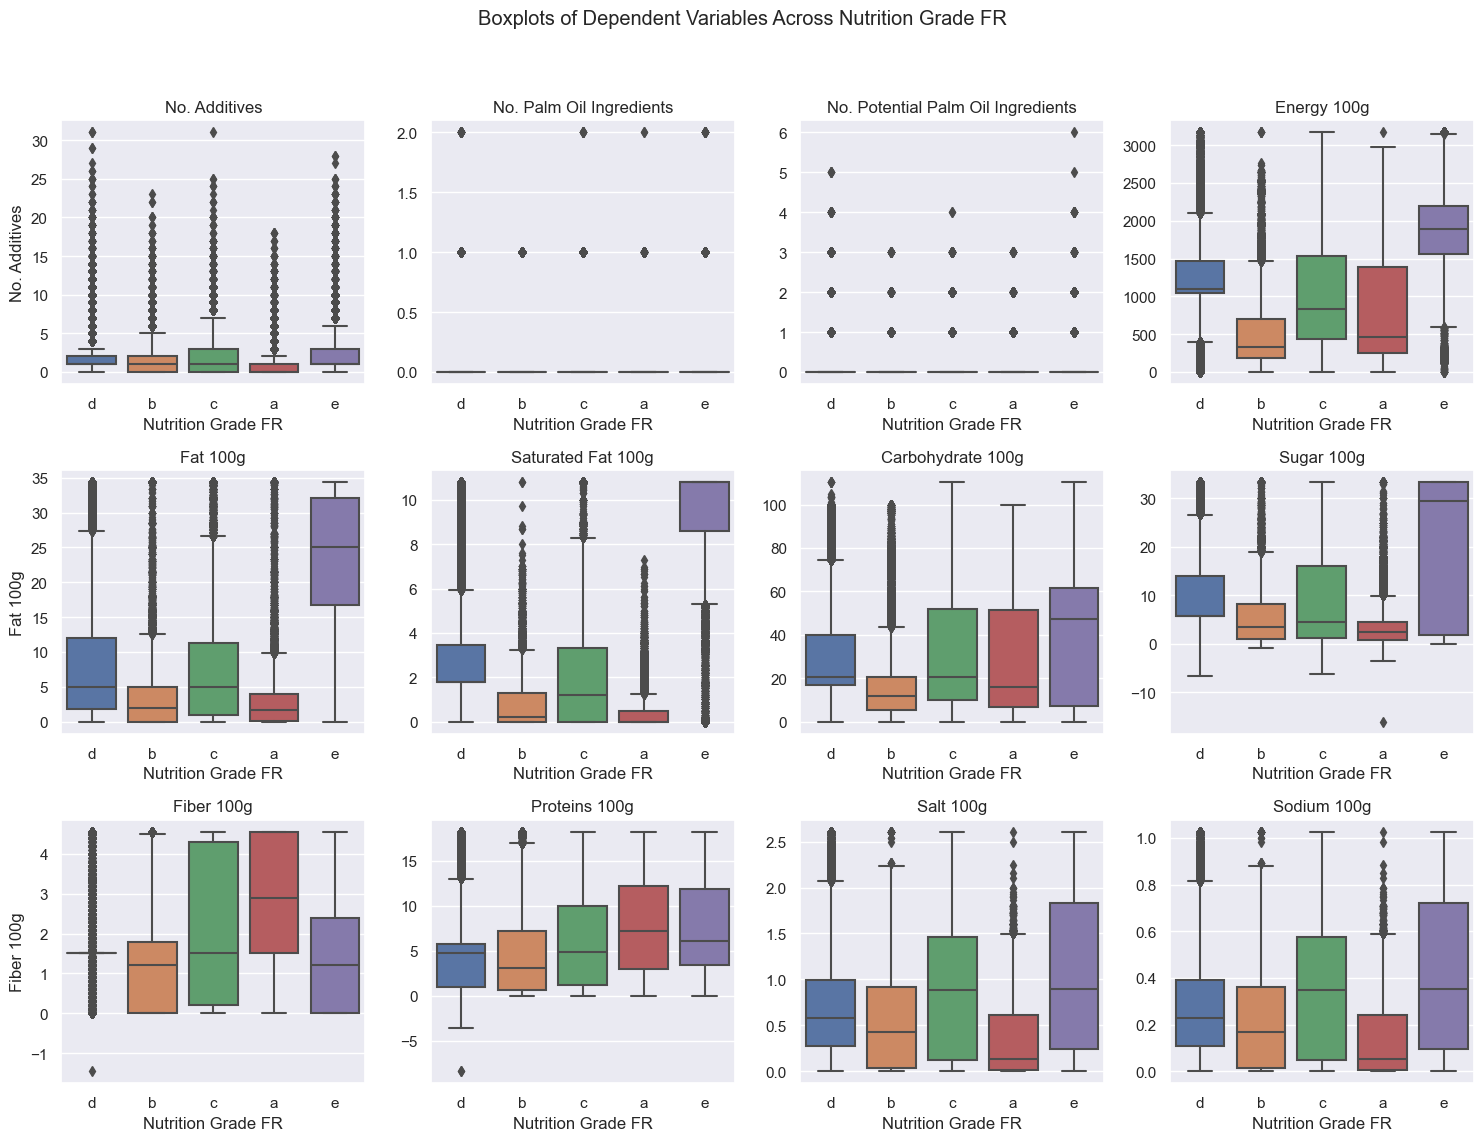

In [47]:
# Purpose: Create a grid of boxplots for each variable in DV, grouped by 'Nutrition Grade FR'

# 1. Determine subplot dimensions
# Calculate the number of rows and columns for the subplots, given a desired number of rows.
num_vars = len(DV)  # Total number of variables to be plotted
num_cols = math.ceil(num_vars / 3)  # Calculate columns based on the desired number of rows
num_rows = 3  # Desired number of rows

# 2. Setup the figure for plotting
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.suptitle('Boxplots of Dependent Variables Across Nutrition Grade FR')

# 3. Plot boxplots for each variable in DV
for idx, var in enumerate(DV):
    row_idx = idx // num_cols
    col_idx = idx % num_cols
    sns.boxplot(x='Nutrition Grade FR', y=var, data=df, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(var)
    
    # Remove y-label for all plots except the first column to prevent overlap
    if col_idx > 0:
        axes[row_idx, col_idx].set_ylabel('')

# 4. Hide any unused subplots
# If the total number of variables isn't a multiple of the desired number of rows, 
# there will be some empty subplots at the end.
unused_subplots = num_cols * num_rows - num_vars
if unused_subplots > 0:
    for j in range(num_cols - unused_subplots, num_cols):
        axes[num_rows - 1, j].axis('off')

# 5. Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# Chi Squared Test

1. **Chi-Squared Value**: 
   - The calculated chi-squared value is 134315.83914416732. This statistic measures the difference between the observed frequencies and the expected frequencies if the two variables were independent.
   
2. **P-Value**: 
   - The p-value is 0.0. This is a measure of the evidence against a null hypothesis. The null hypothesis for the chi-squared test is that the variables are independent. 
   - A p-value of 0.0 (or very close to 0) means that the observed frequencies significantly deviate from what we would expect if the variables were independent. 

3. **Interpretation**: 
   - The statement "The variables are associated (p-value < 0.05)" means that given the p-value, there's strong evidence to reject the null hypothesis of independence. Thus, there is a statistically significant relationship or association between the variables in question.

4. **Observed vs Expected Frequencies**: 
   - For each category (Q1, Q2, Q3, Q4), there are observed and expected frequencies for each Nutrition Grade (a, b, c, d, e).
   - The observed frequencies are the actual counts present in the dataset.
   - The expected frequencies are what we would expect to see if the two variables (quantile category and Nutrition Grade) were independent.
   - Comparing observed to expected, we can see significant discrepancies. For instance, in Category Q1 for Nutrition Grade 'a', the observed value is 18741, while the expected value is 8937.16. This significant difference is reflected across many other categories and grades, indicating a non-random association between the two variables.

5. **Inference**:
   - There's a clear pattern where the observed and expected frequencies differ substantially across various categories and grades. 
   - This provides additional context for why the p-value is so low. The marked differences between observed and expected frequencies across various categories indicate a clear association between the two variables.
   - For example, in Category Q4 for Nutrition Grade 'e', there's a huge difference with observed values being 31920 and expected values being 10588.34. This kind of stark contrast suggests that the distribution of Nutrition Grades within this quantile category (Q4) is not random but influenced by some other factors or inherent properties of the data.

In summary, the results from the chi-squared test and the breakdown of observed vs. expected frequencies strongly suggest that there's a significant association between the quantile category of a certain variable (like 'Energy 100g') and the 'Nutrition Grade FR'.

Chi-Squared Value: 134315.83914416732
P-Value: 0.0
The variables are associated (p-value < 0.05)


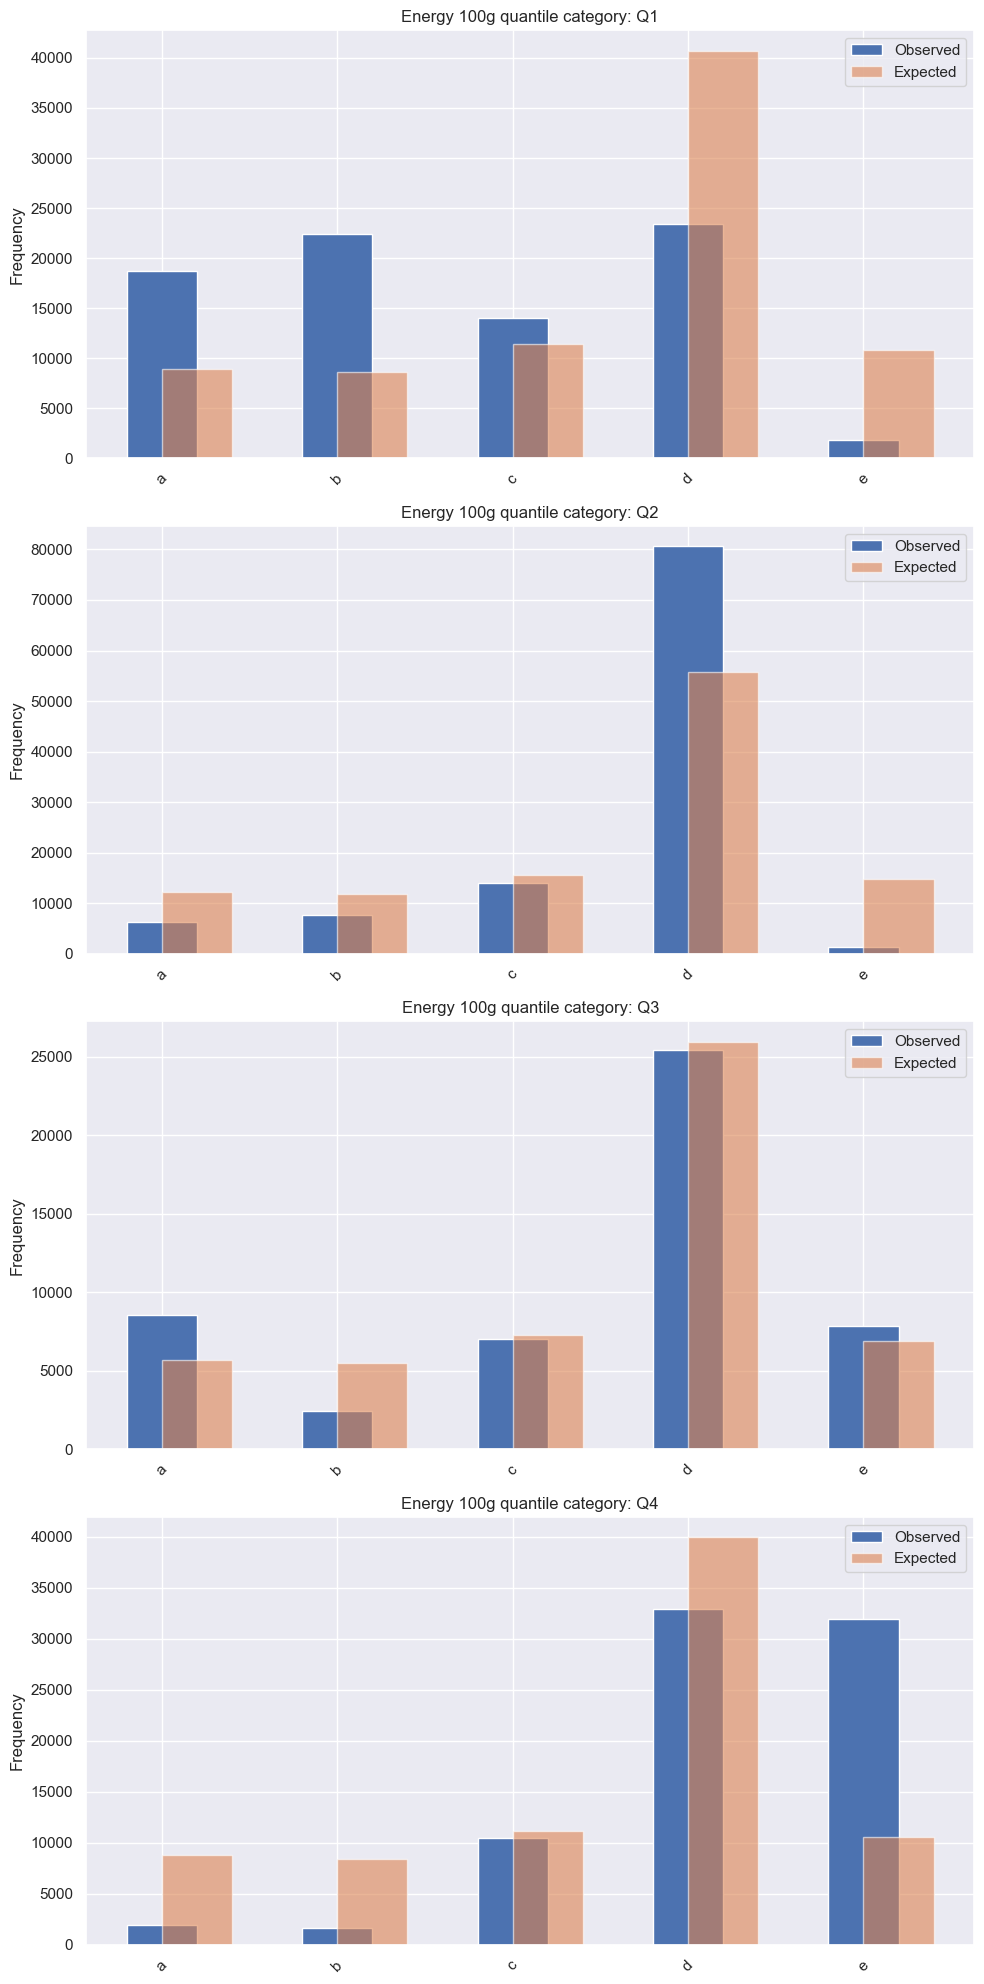

In [48]:
def create_quantile_category(df, column_name):
    # Step 1: Calculate quantile categories for the given column
    quantile_categories = pd.qcut(df[column_name], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
    
    # Step 2: Create a new column with the quantile categories
    df[column_name + ' quantile category'] = quantile_categories
    
    # Step 3: Return the modified DataFrame
    return df

def visualize_chi_squared_subplots(df, col1, col2):
    # Prepare Contingency Table
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Get Observed and Expected Frequencies
    _, _, _, expected = chi2_contingency(contingency_table)
    
    # Convert expected frequencies to DataFrame for easier manipulation
    expected_df = pd.DataFrame(expected, columns=contingency_table.columns, index=contingency_table.index)
    
    # Step 2: Determine the Number of Subplots
    n_subplots = len(contingency_table.index)
    
    # Create Subplots
    fig, axes = plt.subplots(n_subplots, 1, figsize=(10, 5 * n_subplots))
    
    # Step 3: Iterate and Plot
    for idx, (category, ax) in enumerate(zip(contingency_table.index, axes)):
        observed_values = contingency_table.loc[category]
        expected_values = expected_df.loc[category]

        #print(f"Category {category}: Observed Values - {observed_values} | Expected Values - {expected_values}")
        
        labels = observed_values.index
        bar_positions = range(len(labels))
        
        ax.bar(bar_positions, observed_values, width=0.4, label='Observed', align='center')
        ax.bar(bar_positions, expected_values, width=0.4, label='Expected', align='edge', alpha=0.6)
        
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_title(f"{col1}: {category}")
        ax.set_ylabel("Frequency")
        ax.legend()

    plt.tight_layout()
    plt.show()

def chi_squared_test(df, col1, col2):
    # Step 2: Prepare Contingency Table
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Step 3: Perform Chi-Squared Test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Step 4: Interpret the Results
    if p < 0.05:
        result = "The variables are associated (p-value < 0.05)"
    else:
        result = "The variables are not associated (p-value >= 0.05)"
    
    return chi2, p, result


# Usage:
data = create_quantile_category(data, 'Energy 100g')
chi2, p, interpretation = chi_squared_test(data, 'Energy 100g quantile category', 'Nutrition Grade FR')
print(f"Chi-Squared Value: {chi2}")
print(f"P-Value: {p}")
print(interpretation)
visualize_chi_squared_subplots(data, 'Energy 100g quantile category', 'Nutrition Grade FR')
